In [1]:
import pickle
import numpy as np
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from IPython.display import Image as display_image

In [2]:
class okiya():
    
    def __init__(self):
        
        self.observation = np.zeros([11,16])        
        ########
        # Observation
        # 
        # 0:'Rising sun',
        # 1:'Tanzaku',
        # 2:'Bird',
        # 3:'Rain clouds',
        # 4:'Maple leaves',
        # 5:'Cherry tree',
        # 6:'Pine tree',
        # 7:'Iris',
        # 8:'Player 0',
        # 9:'Player 1',
        # 10:'Opponent last action',
        # 
        # Defined a 10 layers of game field
        # Each layer have 16 tiles
        # If tile [0] in a layer [0] is set to 1, then tile [0] have 'Rising sun'
        # If tile [0] in a layer [4] is set to 1, then tile [0] have 'Maple leaves' also
        # 16-cell format used only for human-friendly representation and rendering
        ########
        
        # Fill by the 1-16
        self.tile_map = []
        for a in range(4):
            for b in range(4,8):
                self.tile_map.append([a,b])
        state = np.array([i for i in range(16)])
        self.obs_unzip(state)
        
        self.verbose = True
        
        
    def action_sample(self):
        #action = np.zeros([16])
        action = np.random.rand(16)
        #action[0] = 1
        #np.random.shuffle(action)
        #return np.random.randint(8, size=(1))
        return action
    
        
    def step(self, action):
        reward = 0
        done = 0
        
        # Normalize action
        action[action.argmax()] = 1
        action[action != action.max()] = 0
        
        # Define, which player's turn
        player_layer = 9 if np.sum(self.observation[8])>np.sum(self.observation[9]) else 8        
        
        ### Catch the errors
        error_description = '0: Step to several cells at once'
        if np.sum(action)>1:
            reward -= 0.1
            done = 1
            if self.verbose:
                print(error_description)
        
        error_description = '1: Step to the busy cell'
        busy_cell_test = np.max(action + self.observation[8] + self.observation[9])<2
        if not busy_cell_test:
            reward -= 0.1
            done = 1
            if self.verbose:
                print(error_description, np.where(action==1)[0][0])
        
        error_description = '2: New tail have no relation with pervious'
        if np.max(self.observation[10])>0:
            index = np.where(self.observation[10]==1)[0][0]
            index = env.obs_zip()[index]
            opponent_turn_signs = self.tile_map[index]
            index = np.where(action==1)[0][0]
            index = env.obs_zip()[index]
            action_signs = self.tile_map[index]
            sign_a_relation = action_signs[0] in opponent_turn_signs
            sign_b_relation = action_signs[1] in opponent_turn_signs        
            if sign_a_relation == False and sign_b_relation == False:
                reward -= 0.1
                done = 1
                if self.verbose:
                    print(error_description, np.where(action==1)[0][0])
                    
        error_description = '3: Step into the forbidden zone at the start of the game'
            
        # Set opponent last action
        self.observation[10] = action
        
        # Append Player's tile on to game field
        if busy_cell_test:            
            self.observation[player_layer] += action
        
        return reward, done
    
    
    def reset(self):
        self.observation = np.zeros([11,16])
        state = np.array([i for i in range(16)])
        np.random.shuffle(state)
        self.obs_unzip(state)        
    
    
    def obs_zip(self): # 8-layer -> 16-cell format
        tiles_human_view = []
        # step thru all cells
        for cell in range(16):
            cell_values = []
            # step thru all levels
            for layer in range(0,len(env.observation)-3):
                if env.observation[layer][cell]:
                    cell_values.append(layer)
            for tile in range(len(self.tile_map)):
                if self.tile_map[tile] == cell_values:
                    tiles_human_view.append(tile)
        return np.array(tiles_human_view)
    
    
    def obs_unzip(self, tiles): # 16-cell -> 8-layer format
        i = 0
        for tile in tiles:            
            a = self.tile_map[tile][0]
            b = self.tile_map[tile][1]
            self.observation[a][i] = 1
            self.observation[b][i] = 1
            i += 1
    
    
    def render(self, draw_numbers = True, hi_res = True, draw_player_tiles = True):
        tiles_reshaped = self.obs_zip().reshape([4,4])
        if self.verbose:
            print(tiles_reshaped)
        if draw_player_tiles:
            p1_reshaped = self.observation[8].reshape([4,4])
            p2_reshaped = self.observation[9].reshape([4,4])
            for row in range(4):
                for col in range(4):
                    if p1_reshaped[row][col]:
                        tiles_reshaped[row][col] = 16
                    elif p2_reshaped[row][col]:
                        tiles_reshaped[row][col] = 17
        i = 0
        tile_row = None
        for row in range(4):
            for col in range(4):
                tile_id = str(int(tiles_reshaped[row][col]))

                if hi_res:
                    filename = 'higardentile'+tile_id+'.png'
                    im = Image.open('images/'+filename)
                    im = im.resize((464,464), Image.ANTIALIAS)
                    number_size = 320
                else:
                    filename = 'lowgardentile'+tile_id+'.png'
                    im = Image.open('images/'+filename)
                    im = im.resize((115,115), Image.ANTIALIAS)
                    number_size = 80

                if draw_numbers:
                    if tile_id == '16':
                        tile_id = 'P1'
                    elif tile_id == '17':
                        tile_id = 'P2'
                    im = self.draw_text(tile_id, number_size, (50, 255, 50), im)

                if col == 0:
                    tile = np.array(im)
                else:
                    tile_r = np.array(im)
                    tile = np.concatenate((tile, tile_r), axis=1)
                i += 1
            if row == 0:
                tile_row = tile
            else:
                tile_row = np.concatenate((tile_row, tile), axis=0)

        im = Image.fromarray(tile_row)
        img_path = 'images/tiles.png'
        im.save(img_path)        
        return img_path
    
    def draw_text(self, text, font_size, color, img):
        font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeMono.ttf", font_size, encoding="unic")
        draw = ImageDraw.Draw(img)
        w, h = draw.textsize(text, font)
        draw.text(((img.width - w) / 2, (img.height - h) / 2), text, color, font)
        return img

[[ 8 13  9  4]
 [15  0  6 10]
 [ 5  2 14  7]
 [ 3  1 11 12]]


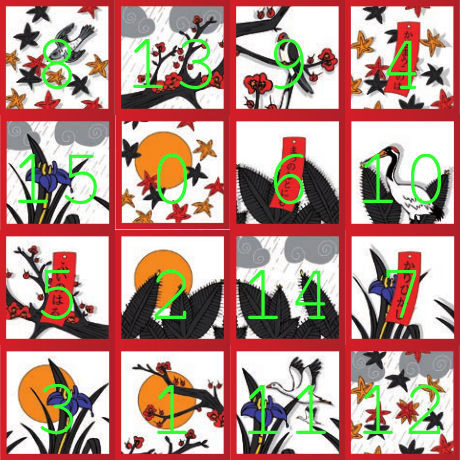

In [10]:
env = okiya()
env.reset()
img_path = env.render(hi_res = False)
display_image(img_path)

2: New tail have no relation with pervious 8
(-0.1, 1)
[[ 8 13  9  4]
 [15  0  6 10]
 [ 5  2 14  7]
 [ 3  1 11 12]]


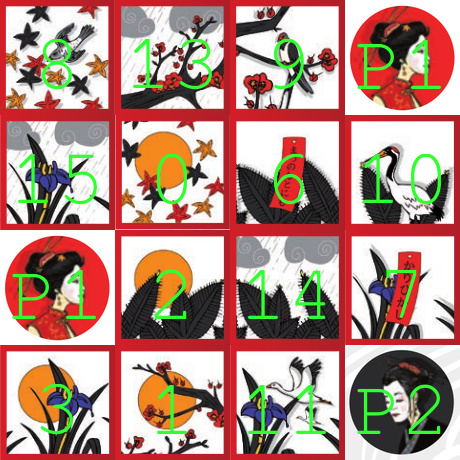

In [13]:
action = env.action_sample()
print(env.step(action))
img_path = env.render(hi_res = False)
display_image(img_path)

In [ ]:
# with open ('obs.pckl', 'wb') as f:
#     pickle.dump(env.observation, f)

In [ ]:
env = okiya()
for episode in range(100):
    env.reset()
    for i in range(10000):
        # we choose action by sampling random action from environment's action space. Every environment has
        # some action space which contains the all possible valid actions and observations,
        action = env.action_sample()
        
        # Then for each step, we will record the observation, reward, done, info
        reward, done = env.step(action)

        # When done is true, we print the time steps taken for the episode and break the current episode.
        if done:
            print("{} timesteps taken for the Episode".format(i+1))
            break
    break